In [35]:
from transformers import AutoTokenizer, AutoModelForCausalLM, GenerationConfig
from rdkit import Chem
from rdkit.Chem import Draw

In [17]:
tokenizer_scaffoldGPT = AutoTokenizer.from_pretrained(f'jarod0411/raw_scaffoldGPT') 
scaffoldGPT = AutoModelForCausalLM.from_pretrained(f'jarod0411/raw_scaffoldGPT')

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [15]:
tokenizer_controlGPT = AutoTokenizer.from_pretrained("jarod0411/controlGPT") 
controlGPT = AutoModelForCausalLM.from_pretrained("jarod0411/controlGPT")

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [21]:
linkerGPT = AutoModelForCausalLM.from_pretrained("jarod0411/linkerGPT")
tokenizer_linkerGPT = AutoTokenizer.from_pretrained("jarod0411/linkerGPT")

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [22]:
generation_config_linkerGPT = GenerationConfig(top_k=20, top_p=0.95, do_sample=True, eos_token_id=tokenizer_linkerGPT.eos_token_id, \
                                     pad_token_id=tokenizer_linkerGPT.pad_token_id, forced_eos_token_id=tokenizer_linkerGPT.eos_token_id, \
                                     max_length=512, num_return_sequences=1)

generation_config_scaffoldGPT = GenerationConfig(top_k=20, top_p=0.95, do_sample=True, eos_token_id=tokenizer_scaffoldGPT.eos_token_id, \
                                     pad_token_id=tokenizer_scaffoldGPT.pad_token_id, forced_eos_token_id=tokenizer_scaffoldGPT.eos_token_id, \
                                     max_length=512, num_return_sequences=1)

generation_config_controlGPT = GenerationConfig(top_k=20, top_p=0.95, do_sample=True, eos_token_id=tokenizer_controlGPT.eos_token_id, \
                                     pad_token_id=tokenizer_controlGPT.pad_token_id, forced_eos_token_id=tokenizer_controlGPT.eos_token_id, \
                                     max_length=512, num_return_sequences=1)

In [23]:
model_dict = {
    'linkerGPT': linkerGPT,
    'controlGPT': controlGPT,
    'scaffoldGPT': scaffoldGPT, 
}

tokenizer_dict = {
    'linkerGPT': tokenizer_linkerGPT,
    'controlGPT': tokenizer_controlGPT,
    'scaffoldGPT': tokenizer_scaffoldGPT, 
}

generation_config_dict = {
    'linkerGPT': generation_config_linkerGPT,
    'controlGPT': generation_config_controlGPT,
    'scaffoldGPT': generation_config_scaffoldGPT, 
}

### scaffoldGPT

In [37]:
k = 'scaffoldGPT'
model, tokenizer, generation_config = model_dict[k], tokenizer_dict[k], generation_config_dict[k]

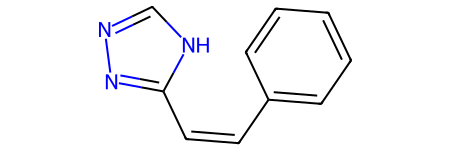

In [36]:
scaffold = 'C(=C\\c1nnc[nH]1)\\c1ccccc1'
Chem.MolFromSmiles(scaffold)

In [53]:
query_tensor = tokenizer.encode(f'<|startoftext|><S>{scaffold}<L>', return_tensors="pt")
output = model.generate(query_tensor, generation_config=generation_config)
output = output[:, query_tensor[0].shape[0] :]
tokenized_output = tokenizer.batch_decode(output, skip_special_tokens=True)

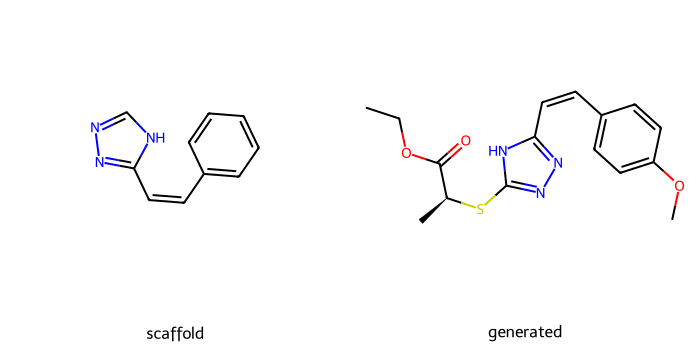

In [54]:
Draw.MolsToGridImage(
    [Chem.MolFromSmiles(scaffold), Chem.MolFromSmiles(tokenized_output[0])],
    molsPerRow=2,
    subImgSize=(350, 350),
    legends=['scaffold', 'generated'],
    useSVG=False
)

In [57]:
dataset

{'smiles': 'O=C([O-])CSc1nnc(/C=C\\c2ccccc2)[nH]1',
 'scaffold_smiles': 'C(=C\\c1nnc[nH]1)\\c1ccccc1',
 'selfies': '[O][=C][Branch1][C][O-1][C][S][C][=N][N][=C][Branch1][O][/C][=C][\\C][=C][C][=C][C][=C][Ring1][=Branch1][NH1][Ring1][=N]',
 'scaffold_selfies': '[C][=Branch1][=Branch2][=C][\\C][=N][N][=C][NH1][Ring1][Branch1][\\C][=C][C][=C][C][=C][Ring1][=Branch1]',
 'QED': 0.8046854515666144,
 'DockingScore': 10.198840141296388,
 'sa': 3.104163059128009,
 'norm_sa': 0.5416676973919975,
 'sol': 0.8170999999999995,
 'norm_sol': 0.3599508305258689,
 'qed': 0.8046854515666144,
 'dock': 10.198840141296388,
 'norm_dock': 0.5248550176620486}

### controlGPT

In [55]:
k = 'controlGPT'
model, tokenizer, generation_config = model_dict[k], tokenizer_dict[k], generation_config_dict[k]

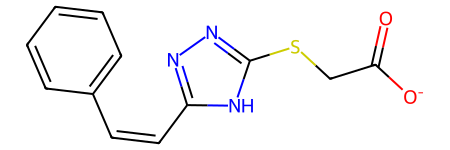

In [58]:
smiles = 'O=C([O-])CSc1nnc(/C=C\\c2ccccc2)[nH]1'
Chem.MolFromSmiles(smiles)

#### mask

In [98]:
def convert_back_mask(d, mask_count=None):
    d = d.split(f"<mask_1:{mask_count}>")
    return d[0] + d[2] + d[1]

def convert_back_s2s(d, mask_count=None, masked=None):
    d = d.split(f"<s2s_{mask_count}:{masked}>")
    return d[0] + d[2] + d[1]

In [84]:
gen_count = 5 # random number
prompt = f'<|startoftext|><L>O=C([O-])CSc1nnc(/C=<mask_1:{gen_count}>2ccccc2)[nH]1<mask_1:{gen_count}>' 
# mask C\\c, mask_1 corresponds that we only have 1 mask here

In [93]:
tensor = tokenizer_dict['controlGPT'].encode(prompt, return_tensors='pt')
output = model_dict['controlGPT'].generate(tensor, generation_config=generation_config_dict['controlGPT'])
out = tokenizer_dict['controlGPT'].decode(output[0][4:-1])
result = convert_back_mask(out, gen_count)
print(out)
print(result)

O=C([O-])CSc1nnc(/C=<mask_1:5>2ccccc2)[nH]1<mask_1:5>C/NNc
O=C([O-])CSc1nnc(/C=C/NNc2ccccc2)[nH]1


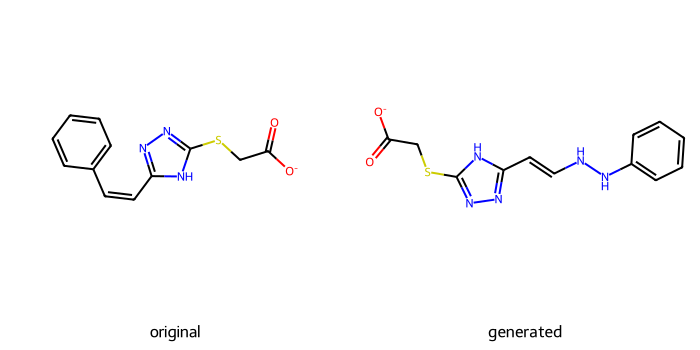

In [94]:
Draw.MolsToGridImage(
    [Chem.MolFromSmiles(smiles), Chem.MolFromSmiles(result)],
    molsPerRow=2,
    subImgSize=(350, 350),
    legends=['original', 'generated'],
    useSVG=False
)

#### s2s

In [95]:
gen_count = 5 # random number
masked = 'C\\c'
prompt = f'<|startoftext|><L>O=C([O-])CSc1nnc(/C=<s2s_{gen_count}:{masked}>2ccccc2)[nH]1<s2s_{gen_count}:{masked}>' 
# mask C\\c, mask_1 corresponds that we only have 1 mask here

In [104]:
tensor = tokenizer_dict['controlGPT'].encode(prompt, return_tensors='pt')
output = model_dict['controlGPT'].generate(tensor, generation_config=generation_config_dict['controlGPT'])
out = tokenizer_dict['controlGPT'].decode(output[0][4:-1])
result = convert_back_s2s(out, gen_count, masked)
print(out)
print(result)

O=C([O-])CSc1nnc(/C=<s2s_5:C\c>2ccccc2)[nH]1<s2s_5:C\c>C\NCc
O=C([O-])CSc1nnc(/C=C\NCc2ccccc2)[nH]1


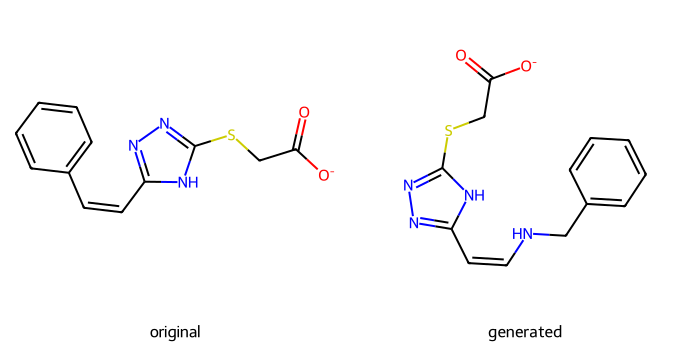

In [105]:
Draw.MolsToGridImage(
    [Chem.MolFromSmiles(smiles), Chem.MolFromSmiles(result)],
    molsPerRow=2,
    subImgSize=(350, 350),
    legends=['original', 'generated'],
    useSVG=False
)

### linker

In [106]:
k = 'linkerGPT'
model, tokenizer, generation_config = model_dict[k], tokenizer_dict[k], generation_config_dict[k]

#### linker

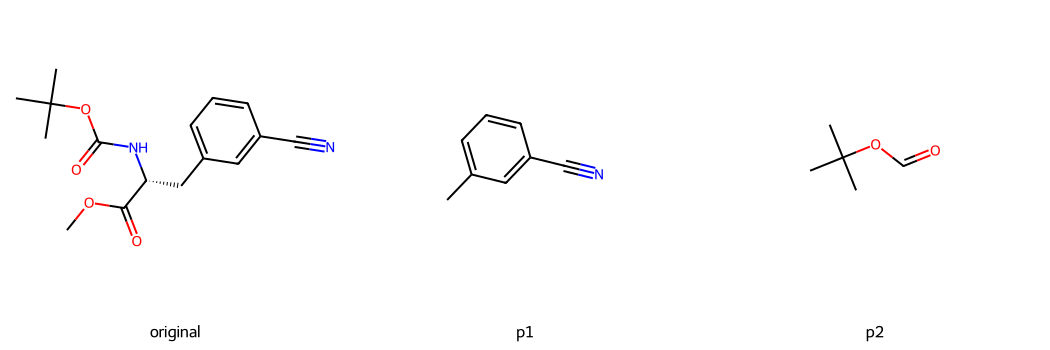

In [109]:
smiles = 'COC(=O)[C@@H](Cc1cccc(C#N)c1)NC(=O)OC(C)(C)C'
p1 = 'Cc1cccc(C#N)c1'
p2 = 'CC(C)(C)OC=O'

Draw.MolsToGridImage(
    [Chem.MolFromSmiles(smiles), Chem.MolFromSmiles(p1), Chem.MolFromSmiles(p2)],
    molsPerRow=3,
    subImgSize=(350, 350),
    legends=['original', 'p1', 'p2'],
    useSVG=False
)

In [116]:
query_tensor = tokenizer.encode(f"<|startoftext|><p1>{p1}<p2>{p2}<L>", return_tensors="pt")
output = linkerGPT.generate(
    query_tensor,
    generation_config=generation_config,
).squeeze()

tokenized_output = tokenizer.decode(output[query_tensor[0].shape[0] :], skip_special_tokens=True)
print(tokenized_output)

C[C@@H]1CN(Cc2cccc(C#N)c2)CCN1C(=O)OC(C)(C)C


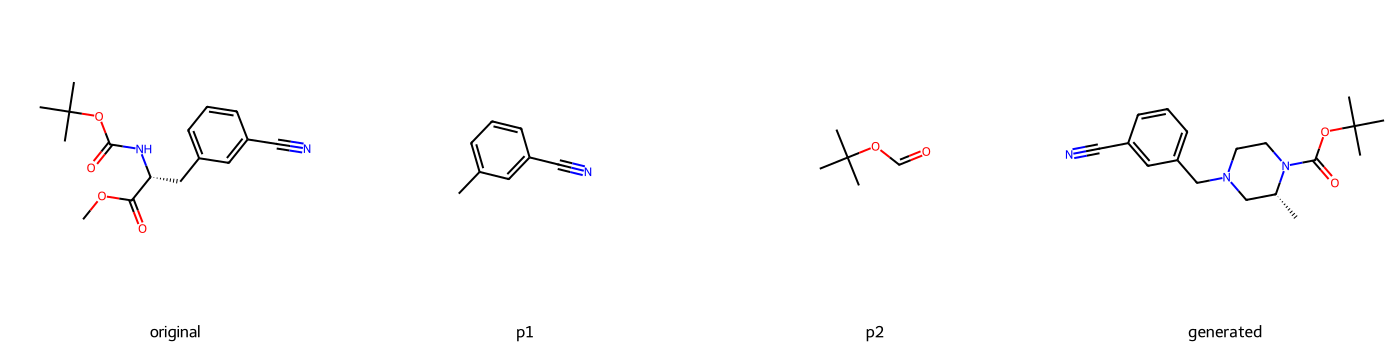

In [118]:
Draw.MolsToGridImage(
    [Chem.MolFromSmiles(smiles), Chem.MolFromSmiles(p1), Chem.MolFromSmiles(p2), Chem.MolFromSmiles(tokenized_output)],
    molsPerRow=4,
    subImgSize=(350, 350),
    legends=['original', 'p1', 'p2', 'generated'],
    useSVG=False
)

#### merger

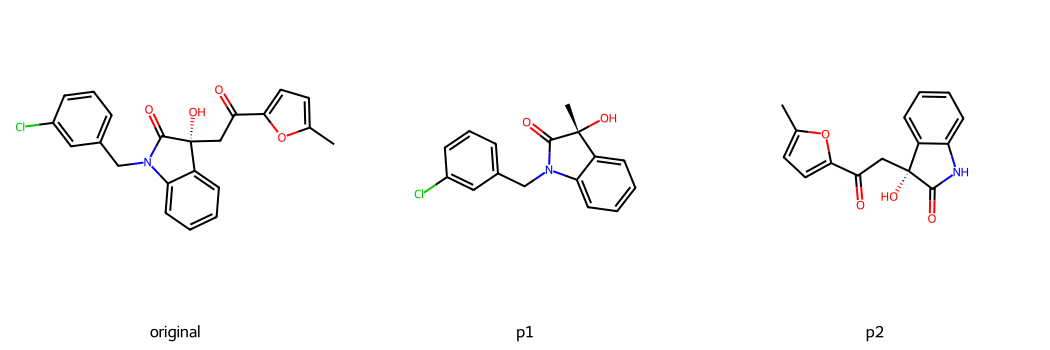

In [119]:
smiles = 'Cc1ccc(C(=O)C[C@]2(O)C(=O)N(Cc3cccc(Cl)c3)c3ccccc32)o1'
p1 = 'C[C@]1(O)C(=O)N(Cc2cccc(Cl)c2)c2ccccc21'
p2 = 'Cc1ccc(C(=O)C[C@]2(O)C(=O)Nc3ccccc32)o1'

Draw.MolsToGridImage(
    [Chem.MolFromSmiles(smiles), Chem.MolFromSmiles(p1), Chem.MolFromSmiles(p2)],
    molsPerRow=3,
    subImgSize=(350, 350),
    legends=['original', 'p1', 'p2'],
    useSVG=False
)

In [133]:
query_tensor = tokenizer.encode(f"<|startoftext|><p1>{p1}<p2>{p2}<L>", return_tensors="pt")


output = linkerGPT.generate(
    query_tensor,
    generation_config=generation_config,
).squeeze()

tokenized_output = tokenizer.decode(output[query_tensor[0].shape[0] :], skip_special_tokens=True)
print(tokenized_output)

Cc1ccc(C(=O)C[C@]2(O)C(=O)N(Cc3cccc(Cl)c3)c3ccccc32)o1


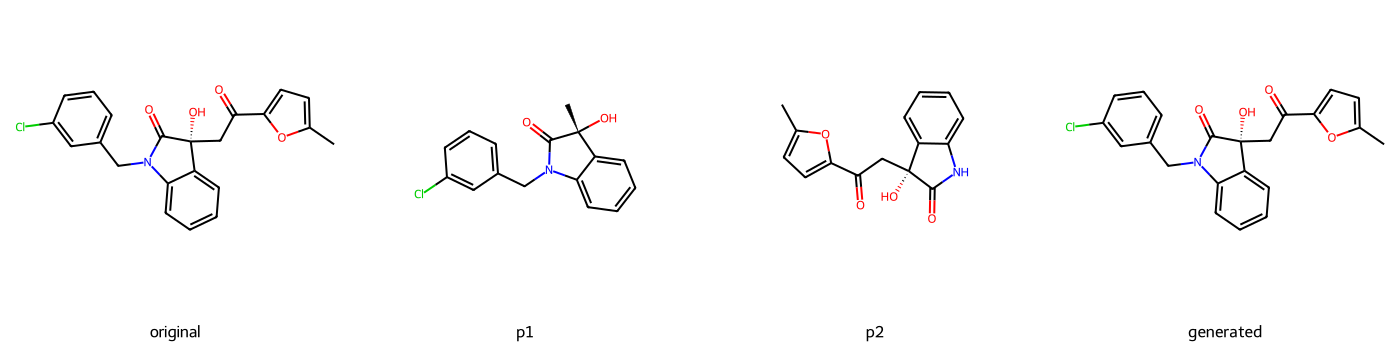

In [134]:
Draw.MolsToGridImage(
    [Chem.MolFromSmiles(smiles), Chem.MolFromSmiles(p1), Chem.MolFromSmiles(p2), Chem.MolFromSmiles(tokenized_output)],
    molsPerRow=4,
    subImgSize=(350, 350),
    legends=['original', 'p1', 'p2', 'generated'],
    useSVG=False
)